In [148]:
from configparser import ConfigParser
import psycopg2
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import recall_score, precision_score
#Can be very helpful to notice any imbalance in classes
from collections import Counter 

In [149]:
#Sourced from https://www.postgresqltutorial.com/postgresql-python/connect/
def config(filename='psql_sample.ini', section='postgresql'):
    parser = ConfigParser()
    # read config file
    parser.read(filename) 
 
    # get section, default to postgresql
    db = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            db[param[0]] = param[1]
    else:
        raise Exception('Section {0} not found in the {1} file'.format(section, filename))
 
    return db

In [150]:
#Get the configuration file as a python dictionary
cfg = config()

#Establish the connection and create a cursor to the database
try:
    print("Here's an attempt to connect to the database")
    conn = psycopg2.connect(**cfg)
    cursor = conn.cursor()
    print("Look's like it was a success")
    
except (Exception, psycopg2.DatabaseError) as error:
    print(error)

Here's an attempt to connect to the database
Look's like it was a success


In [151]:
#SELECT QUERY
try:
    #Lets get our data 
    cursor.execute("SELECT age_group,gender,measures.status,holiday,city,daily_high_temp,daily_low_temp,rain_amount,snow_amount,parks_percentage,retail_and_recreation_percentage,grocery_and_pharmacy_percentage,workplaces_percentage,residential_percentage,transit_stations_percentage,is_fatal,is_resolved,is_unresolved from data_mart.fact_table as fact inner join data_mart.mobility_dimension as mobility on fact.mobility_key=mobility.mobility_key inner join data_mart.weather_dimension as weather on fact.weather_key=weather.weather_key inner join data_mart.patient_dimension as patient on fact.patient_key=patient.patient_key inner join data_mart.special_measures_dimension as measures on fact.special_measures_key=measures.special_measures_key inner join data_mart.phu_location_dimension as phu on fact.phu_location_key=phu.phu_location_key inner join data_mart.reported_date_dimension as date on fact.reported_date_key=date.reported_date_key") 

    #Get the complete result set. It will be a list of tuples where each tuple is a row from the result set
    result_list = cursor.fetchall()
        
except (Exception, psycopg2.DatabaseError) as error:
    print(error)

In [152]:
#Ensure to run this cell at the end of all your experiments to close all connections
cursor.close()
conn.close()

In [153]:
#Now,  1
result_df = pd.DataFrame(result_list, columns=["age_group","gender","status","holiday","city","daily_high","daily_low","rain_amount","snow_amount", "parks_percentage", "retail_and_recreation_percentage","grocery_and_pharmacy_percentage","workplaces_percentage","residential_percentage","transit_stations_percentage",
                                               "is_fatal", "is_resolved","is_unresolved"])

result_df.drop(columns=['daily_high'], inplace=True)
result_df.drop(columns=['daily_low'], inplace=True)
result_df.drop(columns=['rain_amount'], inplace=True)
result_df.drop(columns=['snow_amount'], inplace=True)
#result_df.drop(columns=['workplaces_percentage'], inplace=True)
#result_df.drop(columns=['residential_percentage'], inplace=True)
#result_df.drop(columns=['transit_stations_percentage'], inplace=True)
result_df.drop(columns=['is_resolved'], inplace=True)
result_df.drop(columns=['is_unresolved'], inplace=True)

result_df.head()

,age_group,gender,status,holiday,city,parks_percentage,retail_and_recreation_percentage,grocery_and_pharmacy_percentage,workplaces_percentage,residential_percentage,transit_stations_percentage,is_fatal
0,40s,MALE,Private gathering restrictions,False,Mississauga,71.0,-15.0,-1.0,-44.0,13.0,-57.0,False
1,50s,MALE,Private gathering restrictions,False,Mississauga,71.0,-15.0,-1.0,-44.0,13.0,-57.0,False
2,<20,MALE,Private gathering restrictions,False,Mississauga,71.0,-15.0,-1.0,-44.0,13.0,-57.0,False
3,30s,MALE,Private gathering restrictions,False,Mississauga,71.0,-15.0,-1.0,-44.0,13.0,-57.0,False
4,20s,MALE,Private gathering restrictions,False,Newmarket,NaN,-11.0,4.0,-50.0,16.0,-52.0,False


In [154]:
#Removing null values : 2
result_df["parks_percentage"].fillna(result_df["parks_percentage"].mean(), inplace=True)
result_df["grocery_and_pharmacy_percentage"].fillna(result_df["grocery_and_pharmacy_percentage"].mean(), inplace=True)
result_df["retail_and_recreation_percentage"].fillna(result_df["retail_and_recreation_percentage"].mean(), inplace=True)
result_df["workplaces_percentage"].fillna(result_df["workplaces_percentage"].mean(), inplace=True)
result_df["residential_percentage"].fillna(result_df["residential_percentage"].mean(), inplace=True)
result_df["transit_stations_percentage"].fillna(result_df["transit_stations_percentage"].mean(), inplace=True)

result_df.head()

,age_group,gender,status,holiday,city,parks_percentage,retail_and_recreation_percentage,grocery_and_pharmacy_percentage,workplaces_percentage,residential_percentage,transit_stations_percentage,is_fatal
0,40s,MALE,Private gathering restrictions,False,Mississauga,71.000000,-15.0,-1.0,-44.0,13.0,-57.0,False
1,50s,MALE,Private gathering restrictions,False,Mississauga,71.000000,-15.0,-1.0,-44.0,13.0,-57.0,False
2,<20,MALE,Private gathering restrictions,False,Mississauga,71.000000,-15.0,-1.0,-44.0,13.0,-57.0,False
3,30s,MALE,Private gathering restrictions,False,Mississauga,71.000000,-15.0,-1.0,-44.0,13.0,-57.0,False
4,20s,MALE,Private gathering restrictions,False,Newmarket,16.937927,-11.0,4.0,-50.0,16.0,-52.0,False


In [155]:
#get counter 6
Counter(result_df['is_fatal'])

Counter({False: 83387, True: 1425})

In [156]:
#Get the labels 3
y_under = result_df["is_fatal"]#label


In [157]:
#normalize
#Normalizing data:
transform_data = result_df[["retail_and_recreation_percentage","grocery_and_pharmacy_percentage","parks_percentage","workplaces_percentage","residential_percentage","transit_stations_percentage"]]
X_normalized=preprocessing.normalize(transform_data,norm='l2')
normalize_part=pd.DataFrame(X_normalized,columns=transform_data.columns)
non_numerical=result_df[["status","age_group","is_fatal","city","gender","holiday"]]
result_data=pd.concat([non_numerical,normalize_part],axis=1)
result_data.head()

,status,age_group,is_fatal,city,gender,holiday,retail_and_recreation_percentage,grocery_and_pharmacy_percentage,parks_percentage,workplaces_percentage,residential_percentage,transit_stations_percentage
0,Private gathering restrictions,40s,False,Mississauga,MALE,False,-0.145549,-0.009703,0.688931,-0.426943,0.126142,-0.553085
1,Private gathering restrictions,50s,False,Mississauga,MALE,False,-0.145549,-0.009703,0.688931,-0.426943,0.126142,-0.553085
2,Private gathering restrictions,<20,False,Mississauga,MALE,False,-0.145549,-0.009703,0.688931,-0.426943,0.126142,-0.553085
3,Private gathering restrictions,30s,False,Mississauga,MALE,False,-0.145549,-0.009703,0.688931,-0.426943,0.126142,-0.553085
4,Private gathering restrictions,20s,False,Newmarket,MALE,False,-0.143404,0.052147,0.220815,-0.651835,0.208587,-0.677908


In [158]:
#drop the label
result_data.drop(columns=['is_fatal'], inplace=True)
#result_df.drop(columns=['is_fatal'], inplace=True)

In [159]:
# Our features have categorical data. We need to convert them to one-hot encoders to get the best results.
new_result_df = pd.get_dummies(result_data)
new_result_df.head()

,holiday,retail_and_recreation_percentage,grocery_and_pharmacy_percentage,parks_percentage,workplaces_percentage,residential_percentage,transit_stations_percentage,status_Acitivies closures,status_Control,status_Lockdown,...,city_Mississauga,city_Newmarket,city_Oakville,city_Ottawa,city_Toronto,city_Whitby,gender_FEMALE,gender_GENDER DIVERSE,gender_MALE,gender_UNSPECIFIED
0,False,-0.145549,-0.009703,0.688931,-0.426943,0.126142,-0.553085,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,False,-0.145549,-0.009703,0.688931,-0.426943,0.126142,-0.553085,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,False,-0.145549,-0.009703,0.688931,-0.426943,0.126142,-0.553085,0,0,0,...,1,0,0,0,0,0,0,0,1,0
3,False,-0.145549,-0.009703,0.688931,-0.426943,0.126142,-0.553085,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,False,-0.143404,0.052147,0.220815,-0.651835,0.208587,-0.677908,0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [160]:
#Undersampling of majority classes:  4
from imblearn.under_sampling import NearMiss
X = new_result_df.values#features
undersample = NearMiss(version=1,n_neighbors=3)
x_under, y_under = undersample.fit_resample(X,y_under)

In [161]:
X_train, X_test, y_train, y_test = train_test_split(x_under, y_under, test_size=0.33, shuffle=True, stratify=y_under)

In [162]:
#Let's see the no. of records per class in training and test set
print("Training set {} ".format(Counter(y_train)))
print("Test set {} ".format(Counter(y_test)))

Training set Counter({True: 955, False: 954}) 
Test set Counter({False: 471, True: 470}) 


In [163]:
#PART B
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score, precision_score, accuracy_score
import datetime
#Gradient Boosting


#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, stratify=y_under)
a = datetime.datetime.now()
classifier = GradientBoostingClassifier(n_estimators=20, learning_rate=0.75, max_features=2, max_depth=2, random_state=0)
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
b = datetime.datetime.now()
c = b - a

print('time in milliseconds')
print(c.total_seconds() * 1000)
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("Classification Report")
print(classification_report(y_test, predictions))

accuracy = accuracy_score(predictions, y_test) * 100
recall = recall_score(predictions, y_test) * 100
precision = precision_score(predictions, y_test) * 100

print("Accuracy of Gradient Boosting: {:.2f} %".format(accuracy))
print("Precision of Gradient Boosting: {:.2f} %".format(precision))
print("Recall of Gradient Boosting: {:.2f} %".format(recall))


time in milliseconds
31.556
Confusion Matrix:
[[390  81]
 [179 291]]
Classification Report
              precision    recall  f1-score   support

       False       0.69      0.83      0.75       471
        True       0.78      0.62      0.69       470

    accuracy                           0.72       941
   macro avg       0.73      0.72      0.72       941
weighted avg       0.73      0.72      0.72       941

Accuracy of Gradient Boosting: 72.37 %
Precision of Gradient Boosting: 61.91 %
Recall of Gradient Boosting: 78.23 %


<AxesSubplot:>

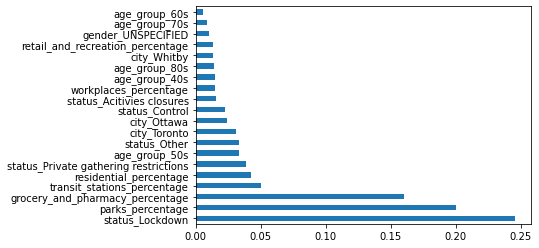

In [164]:
importance = pd.Series(classifier.feature_importances_, index=new_result_df.columns)
importance.nlargest(20).plot(kind='barh')


In [165]:
#Random Forest
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify = y_under)

#create and fit random forest
a = datetime.datetime.now()#start time
rf = RandomForestClassifier(max_depth=2, random_state=0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
b = datetime.datetime.now()#end time
c = b - a

print('time in milliseconds')
print(c.total_seconds() * 1000)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Classification Report")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_pred, y_test) * 100
recall = recall_score(y_pred, y_test) * 100
precision = precision_score(y_pred, y_test) * 100

print("Accuracy of Random Forest: {:.2f} %".format(accuracy))
print("Precision of Random Forest: {:.2f} %".format(precision))
print("Recall of Random Forest: {:.2f} %".format(recall))


time in milliseconds
295.488
Confusion Matrix:
[[390  81]
 [194 276]]
Classification Report
              precision    recall  f1-score   support

       False       0.67      0.83      0.74       471
        True       0.77      0.59      0.67       470

    accuracy                           0.71       941
   macro avg       0.72      0.71      0.70       941
weighted avg       0.72      0.71      0.70       941

Accuracy of Random Forest: 70.78 %
Precision of Random Forest: 58.72 %
Recall of Random Forest: 77.31 %


<AxesSubplot:>

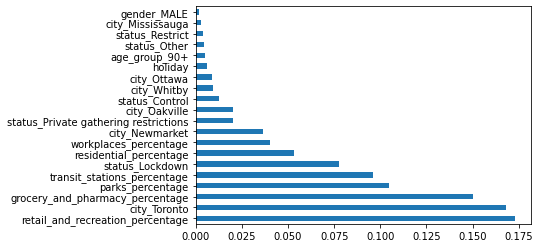

In [169]:
importance = pd.Series(rf.feature_importances_, index=new_result_df.columns)
importance.nlargest(20).plot(kind='barh')


In [166]:
#Decision Tree Algorithm:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)
from sklearn import tree
from matplotlib import pyplot as plt
import graphviz

a = datetime.datetime.now()
dt = DecisionTreeClassifier(criterion='entropy')
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
b = datetime.datetime.now()
c = b - a

print('time in milliseconds')
print(c.total_seconds() * 1000)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Classification Report")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_pred,y_test) * 100  
recall = recall_score(y_pred, y_test) * 100 
precision = precision_score(y_pred, y_test) * 100

print("Accuracy of Decision Tree: {:.2f} %".format(accuracy))
print("Recall of Decision Tree: {:.2f} %".format(recall))
print("Precision of Decision Tree: {:.2f} %".format(precision))



time in milliseconds
16.954
Confusion Matrix:
[[437  34]
 [194 276]]
Classification Report
              precision    recall  f1-score   support

       False       0.69      0.93      0.79       471
        True       0.89      0.59      0.71       470

    accuracy                           0.76       941
   macro avg       0.79      0.76      0.75       941
weighted avg       0.79      0.76      0.75       941

Accuracy of Decision Tree: 75.77 %
Recall of Decision Tree: 89.03 %
Precision of Decision Tree: 58.72 %


<AxesSubplot:>

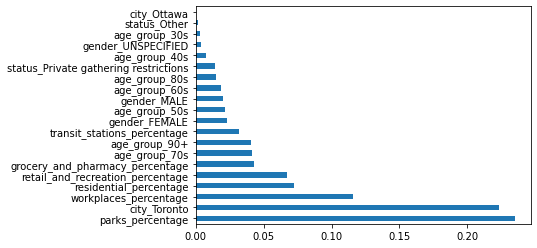

In [170]:
importance = pd.Series(dt.feature_importances_, index=new_result_df.columns)
importance.nlargest(20).plot(kind='barh')

In [167]:
dot_data = tree.export_graphviz(dt, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("DecisionTree") 

'DecisionTree.pdf'

In [168]:
#PART C
from sklearn.svm import OneClassSVM

clf = OneClassSVM(gamma='auto').fit(X_train)
y_pred = clf.predict(X_test)
#array([-1,  1,  1,  1, -1])
Score = clf.score_samples(X_test)
print(Score)
#array([1.7798..., 2.0547..., 2.0556..., 2.0561..., 1.7332...])


[791.43551257 818.84159661 819.26666889 824.3570384  818.46601952
 777.13486935 814.47808642 790.99756142 808.55525139 819.71176563
 813.59565908 814.83037399 785.66244449 808.89114327 791.35699329
 820.20357376 812.95175674 819.08069595 793.93687728 788.3697709
 825.3647144  813.59358387 794.8661533  810.57979595 808.96523769
 818.95482773 820.12528505 815.82944883 801.20449494 812.59313796
 801.58255587 825.07103913 813.59565908 813.15368615 788.85976205
 778.24196134 821.02672328 810.3854577  818.74677475 800.05875307
 815.27799738 787.19810551 815.82944883 817.55428286 809.90564389
 822.78653931 811.76455883 791.03209371 810.16797505 787.81529868
 815.19405871 797.139132   814.78923651 817.78673029 823.14580141
 817.46373781 811.76455883 823.27912022 814.63964414 803.47718354
 812.30348275 825.09445555 820.0221976  805.91671662 793.16638308
 814.83037399 822.78653931 789.05951852 776.67939518 806.90368018
 818.80310085 816.7539862  812.47387857 817.55170792 822.68907632
 812.612179